<a href="https://colab.research.google.com/github/game-addicted-man/2025DLP/blob/main/%EB%94%A5%EB%9F%AC%EB%8B%9D%EC%8B%A4%EC%8A%B5_Imagewoof.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet50으로 Imagewoof 분류해보기<br>
by uramoon@kw.ac.kr

이미 훈련된 ResNet50을 불러와서 견종을 분류합니다.

이 저작물은 <a href="https://creativecommons.org/licenses/by-nc-sa/2.0/kr/">CC BY-NC-SA 2.0 KR</a>에 따라 이용할 수 있습니다. (단, 라이선스가 명시된 일부 문서 및 삽화 제외)<br>
기여하신 문서의 저작권은 각 기여자에게 있으며, 각 기여자는 기여하신 부분의 저작권을 갖습니다.<br>
Imagewoof 출처 : https://github.com/fastai/imagenette

ResNet50은 다음과 같이 층을 건너뛰는 skipping connection을 지닌 residual neural network입니다.

<img src="https://production-media.paperswithcode.com/methods/resnet-e1548261477164_2_mD02h5A.png" height="200"/>

https://keras.io/api/applications/ (ImageNet 기준 ResNet50 성능 확인 가능)


## Imagewoof 중 일부만 압축 풀기<br>
KW_Imagewoof를 다운받아 Colab에 복사한 후 진행하세요.

In [2]:
!unzip -q KW_imagewoof2-320.zip

## 클래스 인덱스와 이름 알아보기<br>
KW_imagewoof2-320/n0.. 폴더에는 각 클래스에 해당하는 사진이 있습니다.<br>
(왼쪽 파일 목록을 새로고침하고 KW_imagewoof2-320 폴더를 확인해보세요.)<br><br>
ImageNet은 1,000 개의 클래스를 갖고 있는데 n0..이
1. ImageNet에서 몇 번째 클래스에 해당하는지
2. 사람이 식별하기 위한 이름은 어떻게 되는지 살펴봅시다.<br>
(imagenet_class_index.json 파일 활용)<br>
출처: https://github.com/raghakot/keras-vis/blob/master/resources/imagenet_class_index.json

In [19]:
# 0번째 클래스는 n01440764인 잉어, 1번째 클래스는 n01443537인 금붕어, ...
!head imagenet_class_index.json

{"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829", "house_finch"], "13": ["n01534433", "junco"], "14": ["n01537544", "indigo_bunting"], "15": ["n01558993", "robin"], "16": ["n01560419", "bulbul"], "17": ["n01580077", "jay"], "18": ["n01582220", "magpie"], "19": ["n01592084", "chickadee"], "20": ["n01601694", "water_ouzel"], "21": ["n01608432", "kite"], "22": ["n01614925", "bald_eagle"], "23": ["n01616318", "vulture"], "24": ["n01622779", "great_grey_owl"], "25": ["n01629819", "European_fire_salamander"], "26": ["n01630670", "common_newt"], "27": ["n01631663", "eft"], "28": ["n01632458", "spotted_salamander"], "29": ["n01632777", 

In [20]:
import json
idx2label = []  # 인덱스를 입력하면 사람이 이해할 수 있는 이름표가 나옵니다.
cls2label = {}  # 'n02086240' 같은 것을 입력하면 사람이 이해할 수 있는 이름표가 나옵니다.
cls2idx = {}    # 'n02086240' 같은 것을 입력하면 인덱스가 나옵니다. [0, 999]: 인공신경망의 몇 번째 출력에 해당하는가

with open("imagenet_class_index.json", "r") as read_file:
    class_idx = json.load(read_file)
    idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]
    cls2label = {class_idx[str(k)][0]: class_idx[str(k)][1] for k in range(len(class_idx))}
    cls2idx = {class_idx[str(k)][0]: k for k in range(len(class_idx))}

## TODO1: 딕셔너리 활용하기<br>
아래의 두 개를 출력해보세요.

1. n02086240은 몇 번째 클래스인가? 인덱스를 출력하세요. (모델의 출력에서 사용)
2. n02086240의 클래스 이름은 무엇인가? (인간이 식별하기 편한 이름)

In [21]:
target = 'n02086240'
# TODO: 1번과 2번의 답을 출력해보세요.
index = cls2idx[target]
print("1. target의 인덱스 번호:", index)

label = idx2label[index]
print("2. target의 클래스 이름:", label)

1. target의 인덱스 번호: 155
2. target의 클래스 이름: Shih-Tzu


## TODO2: 각 디렉토리에서 무작위로 5개씩 그려봅시다.<br>
총 10종의 개 이미지가 있으니 50장이 그려집니다.<br>
TODO 표시된 두 줄만 작성하시면 됩니다.

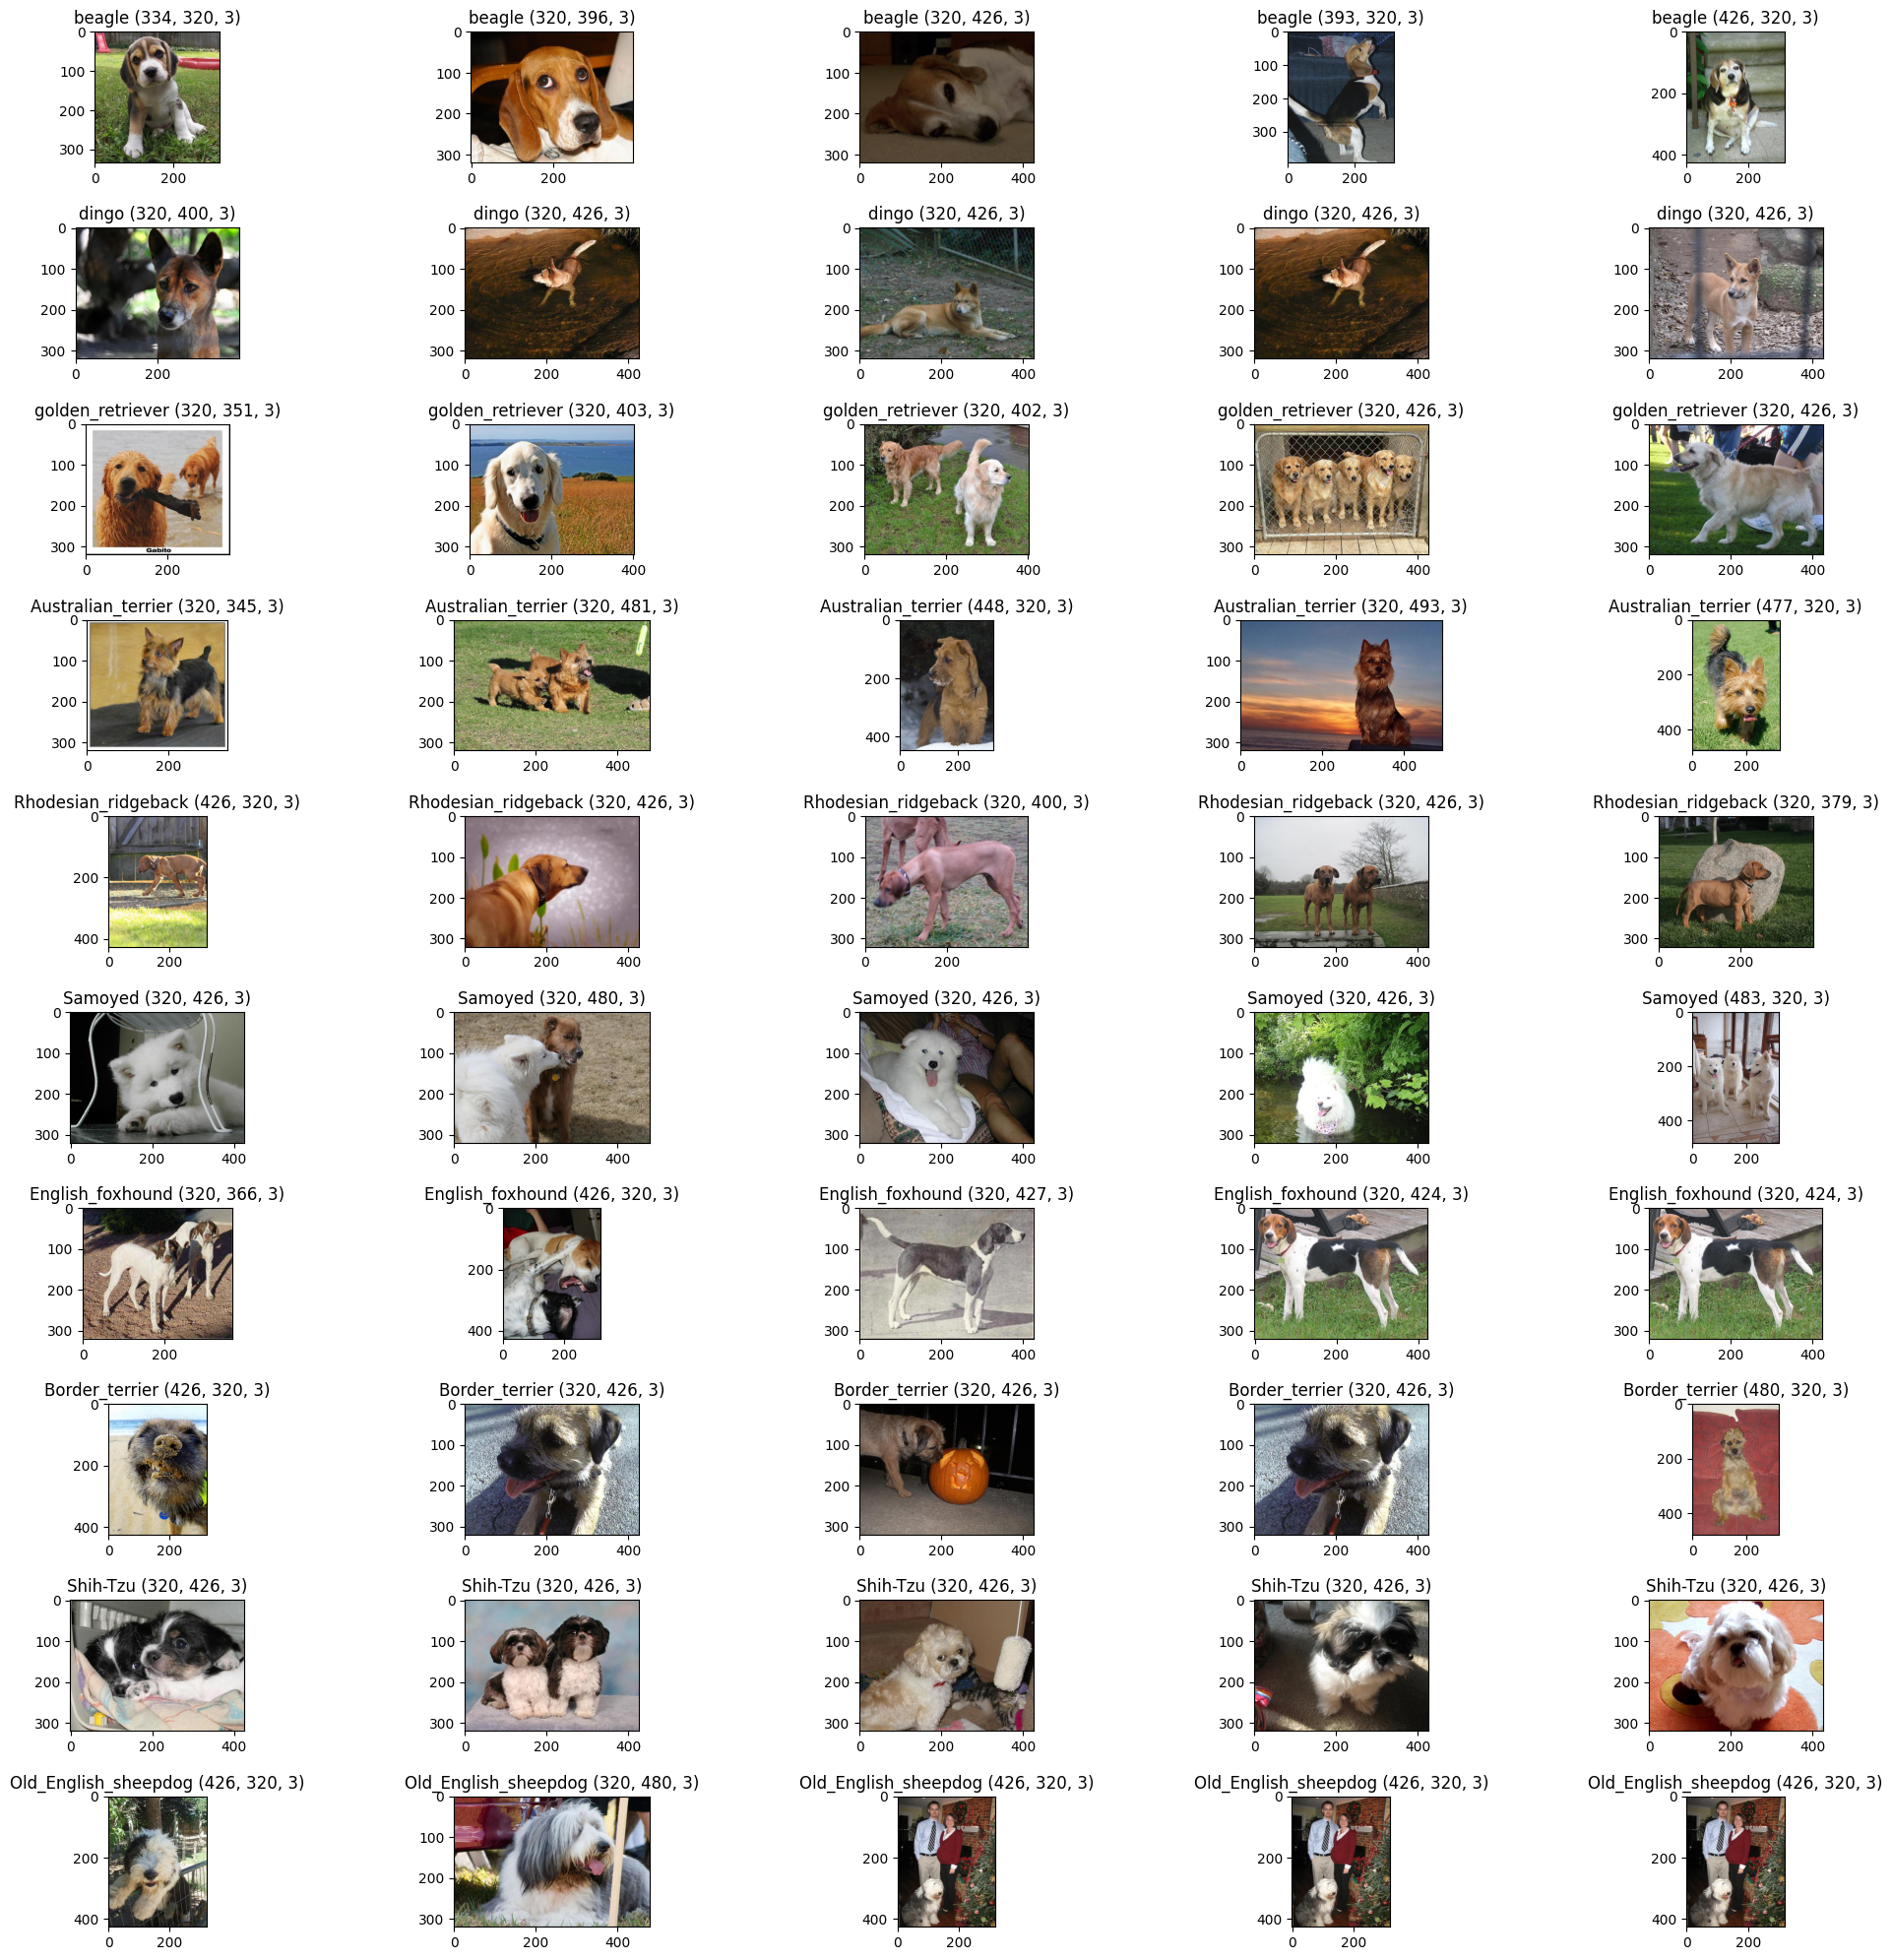

In [22]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# KW_imagewoof2-320 하위 폴더 가져오기
subfolders = [f.path for f in os.scandir('KW_imagewoof2-320') if f.is_dir()]

idx = 1
plt.figure(figsize=(25, 25))
# 각 디렉토리에서
for dir in subfolders:
  # JPEG 파일을 5개씩 무작위로 그리기
  for i in range(5):
    plt.subplot(10, 5, idx)
    idx = idx + 1
    rand_file = random.choice(os.listdir(dir))# TODO: 무작위 파일 선택, Hint: Data augmentation 노트북 참조
    img = mpimg.imread(dir + '/' + rand_file)
    # 각 그림의 제목에 클래스 이름과 그림 사이즈를 출력하세요. (예: golden_triever (높이, 너비, 채널))
    # Hint: 딕셔너리와 img.shape 활용
    plt.title(f"{cls2label[os.path.basename(dir)]} ({img.shape[0]}, {img.shape[1]}, {img.shape[2] if len(img.shape) == 3 else 1})") # TODO: 괄호에 문자열을 넣으면 제목으로 들어감
    plt.imshow(img)
plt.subplots_adjust(hspace=0.5)
plt.show()

## TODO3: JPEG을 224 x 224 크기의 PIL (Python Imaging Library) 이미지로 변환<br>
우리가 사용할 ResNet50은 224 x 224를 입력으로 받습니다.
1. JPEG 그려보기

In [23]:
# 다음 임의의 JPEG 이미지를 그려보세요.
fname = 'KW_imagewoof2-320/n02089973/ILSVRC2012_val_00003671.JPEG'


2. JPEG을 224 x 224 크기의 PIL image로 변환하기<br>
Hint: https://keras.io/api/preprocessing/image/ 에서 load_img 함수 사용

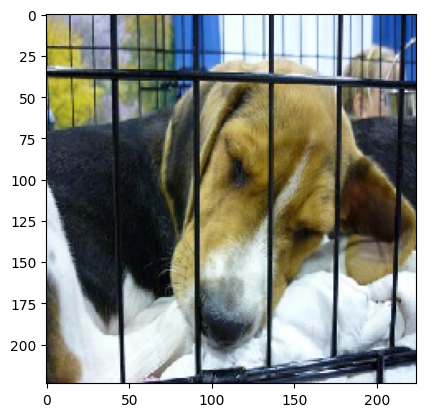

In [24]:
from keras.utils import load_img

# TODO: 상기 JPEG 파일 변환해보기
img_data = load_img(fname, target_size=(224,224))

# img_data 그려보기 (224 x 224로 변환됐는지 반드시 확인)
plt.imshow(img_data)  # TODO: 쉽습니다. 괄호안에 이미지 객체를 넣으세요.

## TODO4: PIL 이미지를 NumPy로 변환하기<br>
Hint: https://keras.io/api/preprocessing/image/ 에서 img_to_array 함수 사용 <br>
컬러 이미지는 3장(RGB: Reds, Greens, Blues)의 채널로 구성됩니다. <br>
실제 컬러 이미지의 채널이 몇 개인지 shape를 확인해보세요.


In [25]:
from keras.utils import img_to_array

# NumPy array로 변환 후 shape 확인하기
array = img_to_array(img_data)
array.shape

(224, 224, 3)

## TODO5: NumPy array 각 채널 (RGB) 그려보기<br>
채널에 따라 적절한 컬러맵을 선택하세요.<br>
https://matplotlib.org/3.5.1/tutorials/colors/colormaps.html <br>
중요: 각 채널의 그림 크기도 224 x 224 인지 확인하고 아니라면 img_data부터 다시 만드세요.

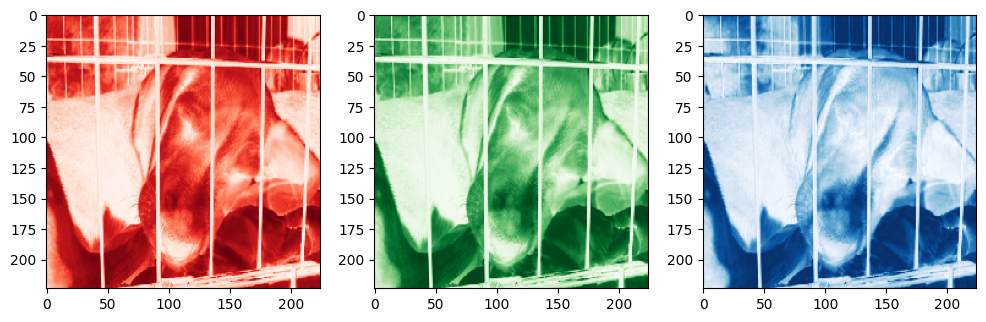

In [26]:
r_img = array[:, :, 0] # TODO: 첫 번째 채널 (R)
g_img = array[:, :, 1] # TODO: 두 번째 채널 (G)
b_img = array[:, :, 2] # TODO: 세 번째 채널 (B)

f, axarr = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.sca(axarr[0])
plt.imshow(r_img, cmap= 'Reds')  # TODO: 첫 번째 채널
plt.sca(axarr[1])
plt.imshow(g_img, cmap= 'Greens')  # TODO: 두 번째 채널
plt.sca(axarr[2])
plt.imshow(b_img, cmap= 'Blues')  # TODO: 세 번째 채널

## TODO6: 테스트 데이터 만들기<br>
이미 훈련이 완료된 ResNet50을 사용하기 때문에 모든 그림을 테스트 데이터로 만들어 성능을 평가해볼 것입니다.<br>
KW_imagewoof2-320 폴더 아래에 있는 모든 이미지에 대해 이미지에 해당하는 NumPy 배열과 인덱스로 구성된 레이블을 만들어야 합니다.<br>
뼈대 코드를 무시하고 자유롭게 만드셔도 됩니다.




In [27]:
from keras.applications.resnet50 import ResNet50
from keras.utils import load_img, img_to_array
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

with open("imagenet_class_index.json", "r") as f:
    class_idx = json.load(f)
cls2idx = {v[0]: int(k) for k, v in class_idx.items()}

X_test = [] # X에는 그림이 들어갑니다.
y_test = [] # y에는 정답(레이블)이 들어갑니다.

# KW_imagewoof2-320 하위 폴더 가져오기
subfolders = [f.path for f in os.scandir('KW_imagewoof2-320') if f.is_dir()]# TODO: 위에서 수행한 적 있습니다.

# 각 디렉토리에서
for dir in subfolders:
  for fname in os.listdir(dir):
    # TODO: load_img를 이용해 224 x 224 PIL 이미지로 읽어오세요.
    img =load_img(dir + '/' + fname, target_size=(224, 224))
    # TODO: PIL 이미지를 NumPy 배열로 변환합니다.
    X = img_to_array(img)
    # ResNet50에서 제공하는 입력 전처리 (별도로 정규화하지 마세요.)
    X = preprocess_input(X)
    X_test.append(preprocess_input(X)) # TODO: 리스트에 그림 하나 추가 (전처리된 NumPy 배열로 추가해야 함)
    y_test.append(cls2idx[os.path.basename(dir)]) # TODO: 리스트에 정답 하나 추가 (몇 번째 클래스인지 인덱스로 추가해야 함)

X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [28]:
# Q: 다음이 의미하는 바는?
# A: 테스트 데이터셋 X_test의 shape를 출력함, 결과가 162, 224, 224, 3으로 나왔음, 162는 162장의 이미지가 있고, 이미지의 크기가 224x224라는 뜻이고, rgb채널 3개를 가진 컬러 이미지임을 의미한다.
print(X_test.shape)

(162, 224, 224, 3)


## ResNet50 불러오기

In [33]:
import numpy as np

# 1000개의 클래스를 지닌 imagenet으로 훈련한 ResNet50 불러오기
model = ResNet50(weights='imagenet')

# 예측하기
preds = model.predict(X_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 714ms/step


## TODO7: 예측 결과 살펴보기<br>
실제의 레이블과 TOP-3 레이블을 비교해보세요.<br>
Hint: https://www.tensorflow.org/api_docs/python/tf/keras/applications/imagenet_utils/decode_predictions

TOP-3는 각 그림에 대해 예측모델이 예측한 가능성이 가장 높은 답안 3개와 실제 답을 비교하여 정확도를 측정합니다.

예: 어떤 그림에 대해 예측모델이 사모예드(50%), 시츄(20%), 비글(10%) 순으로 예측을 했는데 실제 그림이 비글이었으면 정답으로 인정

In [37]:
decodes = decode_predictions(preds, top=3)

for i in range(len(preds)):
  print('Actual:', idx2label[y_test[i]], ', Predicted:', decodes[i]) # TODO: i 번째 이미지의 실제 레이블을 출력해보세요.

Actual: beagle , Predicted: [('n02110341', 'dalmatian', np.float32(0.17151263)), ('n02109961', 'Eskimo_dog', np.float32(0.08864604)), ('n02090622', 'borzoi', np.float32(0.08641544))]
Actual: beagle , Predicted: [('n02092339', 'Weimaraner', np.float32(0.7145295)), ('n02100735', 'English_setter', np.float32(0.032645497)), ('n02088364', 'beagle', np.float32(0.02073159))]
Actual: beagle , Predicted: [('n02088364', 'beagle', np.float32(0.6546575)), ('n02096585', 'Boston_bull', np.float32(0.08448889)), ('n02110806', 'basenji', np.float32(0.058953907))]
Actual: beagle , Predicted: [('n02088238', 'basset', np.float32(0.9227959)), ('n02088466', 'bloodhound', np.float32(0.039706353)), ('n02089078', 'black-and-tan_coonhound', np.float32(0.024836702))]
Actual: beagle , Predicted: [('n02089078', 'black-and-tan_coonhound', np.float32(0.49082547)), ('n02088632', 'bluetick', np.float32(0.28560576)), ('n02088466', 'bloodhound', np.float32(0.10372662))]
Actual: beagle , Predicted: [('n03794056', 'mouset

## TODO8: TOP-1 정확도를 직접 계산해봅시다.
Hint: np.argmax()를 사용하면 배열에서 가장 큰 값을 가진 인덱스를 반환합니다. <br>
예) arr = np.array([10, 20, 30, 40, 50])에서 np.max(arr)은 50이지만, np.argmax(arr)은 4입니다.

In [39]:
correct = 0
incorrect = 0

for i in range(len(preds)):
    if np.argmax(preds[i]) == y_test[i]:
        correct += 1
    else:
        incorrect += 1

acc = correct / (correct + incorrect)
acc = "{:.2%}".format(acc)
print('Accuracy:', acc)

Accuracy: 29.01%
